In [4]:
# 
!pip install rdkit biopython pandas scikit-learn dgl torch qiskit pennylane
!pip install nglview

  Obtaining dependency information for biopython from https://files.pythonhosted.org/packages/c5/7b/c1e9f66e23b01958ae0284a437a0e586ce20387fc6ea0382c21230ac59bc/biopython-1.84-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for dgl from https://files.pythonhosted.org/packages/5d/77/64a2628ee61c47a52b936ef4ebb67fb7632163cefc21258419932d330a0d/dgl-1.1.2.post1-cp311-cp311-macosx_10_10_x86_64.whl.metadata
  Obtaining dependency information for qiskit from https://files.pythonhosted.org/packages/52/07/889a5ff9ca2e4f32428836adc51f6764e5c906029138ab877b99e95651c1/qiskit-1.2.4-cp38-abi3-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for pennylane from https://files.pythonhosted.org/packages/5a/00/f0ed0545b10cbbf484c0a8a5ba46f18f3294fd6e1c3089fcb52908cfe601/PennyLane-0.38.0-py3-none-any.whl.metadata
  Obtaining dependency information for rustworkx>=0.15.0 from https://files.pythonhosted.org/packages/37/06/adeed1d166c55920a6a83085e8c8c8b24c8d770

In [84]:
!pip install biopandas -q
!pip install dgl dglgo -f https://data.dgl.ai/wheels/repo.html -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.4.3 requires pyqt5<5.16, which is not installed.
spyder 5.4.3 requires pyqtwebengine<5.16, which is not installed.


In [85]:
import numpy as np
from biopandas.pdb import PandasPdb
import torch
import dgl

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [134]:
proteins_dir= "./koff_dataset/initial_structure/"

In [563]:
def get_distance_matrix(coords):
    diff_tensor = np.expand_dims(coords, axis=1) - np.expand_dims(coords, axis=0)
    distance_matrix = np.sqrt(np.sum(np.power(diff_tensor, 2), axis=-1))
    return distance_matrix

distance_threshold = 6.0

atom_df = PandasPdb().read_pdb(f"./koff_dataset/initial_structure/1clu_ligand_GppNHP_199_dock1/1clu_ligand_GppNHP_199_dock1_protein.pdb")
atom_df = atom_df.df['ATOM']
residue_df = atom_df.groupby('residue_number', as_index=False)[['x_coord', 'y_coord', 'z_coord', 'b_factor']].mean().sort_values('residue_number')
coords = residue_df[['x_coord', 'y_coord', 'z_coord']].values
distance_matrix = get_distance_matrix(coords)
adj = distance_matrix < distance_threshold
u, v = np.nonzero(adj)
u, v = torch.from_numpy(u), torch.from_numpy(v)
graph = dgl.graph((u, v), num_nodes=len(coords))
b_factor = torch.from_numpy(residue_df['b_factor'].values)
graph.ndata['b_factor'] = b_factor
dgl.save_graphs('dgl_graph.bin', [graph])

graph_list, label_dict = dgl.load_graphs('dgl_graph.bin')
graph = graph_list[0]
label_dict

{}

In [564]:
import networkx as nx
import matplotlib.pyplot as plt

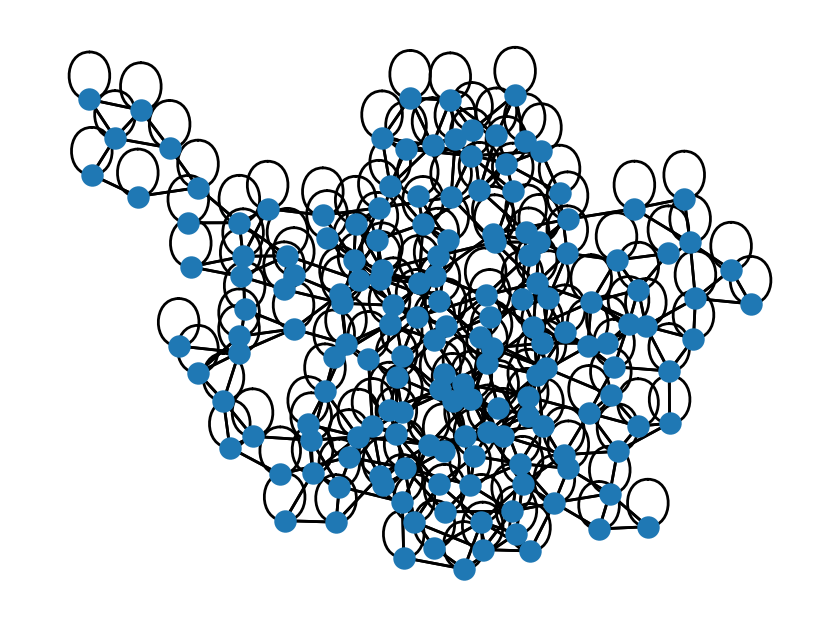

In [565]:
nx_graph = dgl.to_networkx(graph)
plt.figure(figsize=(4, 3), dpi=200)
nx.draw(nx_graph, pos=nx.kamada_kawai_layout(nx_graph), node_size=50, arrows=False)
plt.show()

In [136]:
from biopandas.mol2 import PandasMol2

pmol = PandasMol2().read_mol2(f"{proteins_dir}1clu_ligand_GppNHP_199_dock1/1clu_ligand_GppNHP_199_dock1.mol2")
pmol.df

,atom_id,atom_name,x,y,z,atom_type,subst_id,subst_name,charge
0,1,O1,4.4430,31.5707,21.6969,O.co2,1,UNK,-1.0463
1,2,P2,4.2232,33.0239,21.2377,P.3,1,UNK,1.6324
2,3,O3,4.4757,34.0673,22.3371,O.co2,1,UNK,-1.0463
3,4,O4,2.9266,33.2395,20.4494,O.co2,1,UNK,-1.0463
4,5,N5,5.6506,33.2122,19.9552,N.3,1,UNK,-0.8747
5,6,P6,7.2235,32.4940,20.1544,P.3,1,UNK,1.1447
6,7,O7,7.6254,32.7699,21.5712,O.co2,1,UNK,-0.8679
7,8,O8,7.2627,31.1015,19.5608,O.co2,1,UNK,-0.8679
8,9,O9,8.2071,33.4519,19.1914,O.3,1,UNK,-0.5665
9,10,P10,9.1306,34.8601,19.2731,P.3,1,UNK,1.3132


In [5]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from Bio import PDB


In [6]:
os.getcwd()

'/Users/azamat/Desktop/UC/STDM/project/project_code'

In [9]:
os.listdir('./')

['koff_dataset', 'Koff_QNN.ipynb', '.ipynb_checkpoints']

In [10]:
os.listdir('./koff_dataset/')

['~$koff_index.xlsx',
 '.DS_Store',
 'after_md',
 'initial_structure',
 'README.md',
 'koff_index copy.xlsx',
 'koff_index.csv',
 'README.txt',
 'koff_index.xlsx',
 'structure.txt']

In [465]:
koff_data = pd.read_csv("./koff_dataset/koff_index.csv")

In [466]:
koff_data.head()

,pdbcode,uniprot ID,ligand name,koff/s-1,method,temperature,protein type,smiles,reference,cluster
0,3hec,q16539,3hec_ligand_native_1.mol2,0.38,Surface plasmon resonance,NaN,P38α,O=C(Nc1cc(Nc2nc(-c3cnccc3)ccn2)c(C)cc1)c1ccc(C...,"Biochemistry. 2010, 49, 3611-3618",51
1,3heg,q16539,3heg_ligand_native_2.mol2,0.018,Surface plasmon resonance,NaN,P38α,Clc1c(C(F)(F)F)cc(NC(=O)Nc2ccc(Oc3cc(C(=O)NC)n...,"Biochemistry. 2010, 49, 3611-3618",51
2,NaN,q16539,1kv2_ligand_native_3.mol2,0.0000083,Surface plasmon resonance,NaN,P38α,O=C(Nc1n(-c2ccc(C)cc2)nc(C(C)(C)C)c1)Nc1c2c(c(...,"Biochemistry. 2010, 49, 3611-3618",51
3,NaN,q16539,1kv1_ligand_native_4.mol2,0.062,Surface plasmon resonance,NaN,P38α,Clc1ccc(NC(=O)Nc2n(C)nc(C(C)(C)C)c2)cc1,"Biochemistry. 2010, 49, 3611-3618",51
4,3gcq,q16539,3gcq_ligand_native_5.mol2,1.695e-3/0.046,Fluorescence change,NaN,P38α,O=C(Nc1n(-c2cc(C)ccc2)nc(C(C)(C)C)c1)Nc1ccc(Nc...,"J. AM. CHEM. SOC. 2009, 131, 13286–13296",51


In [467]:
koff_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pdbcode       384 non-null    object 
 1   uniprot ID    669 non-null    object 
 2   ligand name   680 non-null    object 
 3   koff/s-1      680 non-null    object 
 4   method        652 non-null    object 
 5   temperature   404 non-null    float64
 6   protein type  680 non-null    object 
 7   smiles        680 non-null    object 
 8   reference     680 non-null    object 
 9   cluster       680 non-null    int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 53.3+ KB


In [468]:
koff_data = koff_data.drop( ['temperature', 'uniprot ID ', 'reference', 'cluster'] , axis=1)

In [469]:
koff_data.head(50)

,pdbcode,ligand name,koff/s-1,method,protein type,smiles
0,3hec,3hec_ligand_native_1.mol2,0.38,Surface plasmon resonance,P38α,O=C(Nc1cc(Nc2nc(-c3cnccc3)ccn2)c(C)cc1)c1ccc(C...
1,3heg,3heg_ligand_native_2.mol2,0.018,Surface plasmon resonance,P38α,Clc1c(C(F)(F)F)cc(NC(=O)Nc2ccc(Oc3cc(C(=O)NC)n...
2,NaN,1kv2_ligand_native_3.mol2,0.0000083,Surface plasmon resonance,P38α,O=C(Nc1n(-c2ccc(C)cc2)nc(C(C)(C)C)c1)Nc1c2c(c(...
3,NaN,1kv1_ligand_native_4.mol2,0.062,Surface plasmon resonance,P38α,Clc1ccc(NC(=O)Nc2n(C)nc(C(C)(C)C)c2)cc1
4,3gcq,3gcq_ligand_native_5.mol2,1.695e-3/0.046,Fluorescence change,P38α,O=C(Nc1n(-c2cc(C)ccc2)nc(C(C)(C)C)c1)Nc1ccc(Nc...
5,3gcv,3gcv_ligand_native_6.mol2,1.159e-3/0.119,Fluorescence change,P38α,O=C(Nc1n(-c2cc(C)ccc2)nc(C(C)(C)C)c1)Nc1cc(Nc2...
6,3d83,3d83_ligand_native_10.mol2,0.0084,Surface plasmon resonance,P38α,O=C(NCC1CC1)c1ccc(-c2c(C)ccc(NC(=O)c3cc(N4CCOC...
7,3d7z,3d7z_ligand_native_11.mol2,0.023,Surface plasmon resonance,P38α,O=C(NCC1CC1)c1ccc(-c2c(C)ccc(C(=O)NC3CC3)c2)cc1
8,3gcp,3gcp_ligand_native_12.mol2,0.016,Surface plasmon resonance,P38α,[SH0](=O)(C)c1ccc(-c2[nH]c(c(-c3ccc(F)cc3)n2)-...
9,2yiw,2yiw_ligand_native_16.mol2,0.00004,Surface plasmon resonance,P38α,S(c1c(CNC(=O)Nc2n(-c3ccccc3)nc(C(C)(C)C)c2)ccc...


In [470]:
koff_data['method'] = koff_data['method'].str.lower().str.strip().str.replace(r'[\s-]+', '_', regex=True)

# 39 unique 'methods'

In [471]:
koff_data['protein type'] = koff_data['protein type'].str.lower().str.strip().str.replace(r'[\s-]+', '_', regex=True)

# 143 unique 'protein types'

In [556]:
# len(koff_data['protein type'].unique())

143

In [473]:
method_mapping = {
    'surface_plasma_resonance': 'surface_plasmon_resonance',  # Standardizing similar names
    'proteros_reportor_displacement_assay': 'proteros_reporter_displacement',  # Standardizing typo
    'bio_layer_interferometry': 'biolayer_interferometry',  # Standardizing spacing variation
    'biolayer_interferometry_method': 'biolayer_interferometry',  # Standardizing method suffix
    'biolayer_interferometry_(bli)_binding_assay': 'biolayer_interferometry',  # Standardizing
    'a_stopped_flow_fluorescence': 'stopped_flow_fluorescence',  # Standardizing variation
    'fluorescence_polarization_displacement_assay': 'fluorescence_polarization',  # Specific form
    'stopped_flow_spectrometry': 'stopped_flow_spectroscopy',  # Standardizing term
    'stopped_flow_spectrofluorimetry': 'stopped_flow_spectroscopy',  # Standardizing term
    'fpa_assay': 'fluorescence_polarization',  # Mapping abbreviation to full name
    'cold_chase_radiometric_method': 'radioligand_displacement_assay',  # Similar methods
    'steady_state_inhibitor_kinetics': 'steady_state_kinetic_analysis',  # Related method
    'fluorescently_labeled': 'fluorescent_labeled_kinase_assay',  # Standardizing name
    'stopped_flow_kinetics': 'stopped_flow_spectroscopy',  # Mapping to a general method
    'reporter_displacement': 'proteros_reporter_displacement',  # Similar method
    'fluorescence': 'fluorescence_change',  # Assume fluorescence falls under change
    'biacore': 'surface_plasmon_resonance',  # Biacore is a brand of SPR equipment
}

In [474]:
koff_data['method'] = koff_data['method'].replace(method_mapping)

In [475]:
koff_data['method'].unique()

array(['surface_plasmon_resonance', 'fluorescence_change',
       'ret_based_displacement_assay', 'fluorescence_polarization',
       'stopped_flow', 'stopped_flow_competition',
       'stopped_flow_spectroscopy', 'slow_binding_inhibition', nan,
       'proteros_reporter_displacement', 'radioligand_displacement_assay',
       'bioluminescence_resonance_energy_transfer',
       'fluorescent_labeled_kinase_assay', 'biolayer_interferometry',
       'spectrophotometric_method',
       'radiometric_filter_binding_and_spin_column',
       'michaelis_menten_kinetics', 'stopped_flow_fluorescence',
       'isothermal_titration_calorimetry',
       'steady_state_kinetic_analysis', 'radiolabeled',
       'radioligand_binding_analysis'], dtype=object)

In [476]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

encoded_data = encoder.fit_transform(koff_data[['method']])

In [477]:
# Remove rows with NaN values in the 'method' column. There are no NaN values in the protein type column
koff_data = koff_data.dropna(subset=['method'])

In [478]:
koff_data.loc[3]['ligand name'][:4]

'1kv1'

In [491]:
koff_data['pdbcode'] = koff_data['ligand name'].str[:4]

In [492]:
koff_data

,pdbcode,ligand name,koff/s-1,method,protein type,smiles
0,3hec,3hec_ligand_native_1.mol2,0.38,surface_plasmon_resonance,p38α,O=C(Nc1cc(Nc2nc(-c3cnccc3)ccn2)c(C)cc1)c1ccc(C...
1,3heg,3heg_ligand_native_2.mol2,0.018,surface_plasmon_resonance,p38α,Clc1c(C(F)(F)F)cc(NC(=O)Nc2ccc(Oc3cc(C(=O)NC)n...
2,1kv2,1kv2_ligand_native_3.mol2,0.0000083,surface_plasmon_resonance,p38α,O=C(Nc1n(-c2ccc(C)cc2)nc(C(C)(C)C)c1)Nc1c2c(c(...
3,1kv1,1kv1_ligand_native_4.mol2,0.062,surface_plasmon_resonance,p38α,Clc1ccc(NC(=O)Nc2n(C)nc(C(C)(C)C)c2)cc1
4,3gcq,3gcq_ligand_native_5.mol2,1.695e-3/0.046,fluorescence_change,p38α,O=C(Nc1n(-c2cc(C)ccc2)nc(C(C)(C)C)c1)Nc1ccc(Nc...
...,...,...,...,...,...,...
675,3oxc,3oxc_ligand_native_783.mol2,0.00023,surface_plasmon_resonance,hiv_1_protease,O=C(NC(C(O)C[N+H]1C(C(=O)NC(C)(C)C)CC2C(C1)CCC...
676,1hxw,1hxw_ligand_native_784.mol2,0.00216,surface_plasmon_resonance,hiv_1_protease,O=C(OCc1scnc1)NC(C(O)CC(NC(=O)C(NC(=O)N(Cc1nc(...
677,1ohr,1ohr_ligand_native_785.mol2,0.00067,surface_plasmon_resonance,hiv_1_protease,S(CC(NC(=O)c1c(C)c(O)ccc1)C(O)C[N+H]1C(C(=O)NC...
678,2bpx,2bpx_ligand_native_786.mol2,0.00158,surface_plasmon_resonance,hiv_1_protease,O=C(NC1C(O)Cc2c1cccc2)C(CC(O)C[N+H]1C(C(=O)NC(...


In [494]:
koff_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652 entries, 0 to 679
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pdbcode       652 non-null    object
 1   ligand name   652 non-null    object
 2   koff/s-1      652 non-null    object
 3   method        652 non-null    object
 4   protein type  652 non-null    object
 5   smiles        652 non-null    object
dtypes: object(6)
memory usage: 51.8+ KB


In [495]:
koff_data[['koff_main', 'koff_secondary']] = koff_data['koff/s-1'].str.split('/', expand=True)

In [496]:
koff_data

,pdbcode,ligand name,koff/s-1,method,protein type,smiles,koff_main,koff_secondary
0,3hec,3hec_ligand_native_1.mol2,0.38,surface_plasmon_resonance,p38α,O=C(Nc1cc(Nc2nc(-c3cnccc3)ccn2)c(C)cc1)c1ccc(C...,0.38,None
1,3heg,3heg_ligand_native_2.mol2,0.018,surface_plasmon_resonance,p38α,Clc1c(C(F)(F)F)cc(NC(=O)Nc2ccc(Oc3cc(C(=O)NC)n...,0.018,None
2,1kv2,1kv2_ligand_native_3.mol2,0.0000083,surface_plasmon_resonance,p38α,O=C(Nc1n(-c2ccc(C)cc2)nc(C(C)(C)C)c1)Nc1c2c(c(...,0.0000083,None
3,1kv1,1kv1_ligand_native_4.mol2,0.062,surface_plasmon_resonance,p38α,Clc1ccc(NC(=O)Nc2n(C)nc(C(C)(C)C)c2)cc1,0.062,None
4,3gcq,3gcq_ligand_native_5.mol2,1.695e-3/0.046,fluorescence_change,p38α,O=C(Nc1n(-c2cc(C)ccc2)nc(C(C)(C)C)c1)Nc1ccc(Nc...,1.695e-3,0.046
...,...,...,...,...,...,...,...,...
675,3oxc,3oxc_ligand_native_783.mol2,0.00023,surface_plasmon_resonance,hiv_1_protease,O=C(NC(C(O)C[N+H]1C(C(=O)NC(C)(C)C)CC2C(C1)CCC...,0.00023,None
676,1hxw,1hxw_ligand_native_784.mol2,0.00216,surface_plasmon_resonance,hiv_1_protease,O=C(OCc1scnc1)NC(C(O)CC(NC(=O)C(NC(=O)N(Cc1nc(...,0.00216,None
677,1ohr,1ohr_ligand_native_785.mol2,0.00067,surface_plasmon_resonance,hiv_1_protease,S(CC(NC(=O)c1c(C)c(O)ccc1)C(O)C[N+H]1C(C(=O)NC...,0.00067,None
678,2bpx,2bpx_ligand_native_786.mol2,0.00158,surface_plasmon_resonance,hiv_1_protease,O=C(NC1C(O)Cc2c1cccc2)C(CC(O)C[N+H]1C(C(=O)NC(...,0.00158,None


In [497]:
# convert to numeric, keeping NaN for missing secondary values
koff_data['koff_main'] = pd.to_numeric(koff_data['koff_main'], errors='coerce')
koff_data['koff_secondary'] = pd.to_numeric(koff_data['koff_secondary'], errors='coerce')

In [498]:
# choose inputs with only one Koff, unambiguous.

koff_data_cleaned = koff_data.loc[koff_data['koff_secondary'].isna()].drop(columns=["koff_secondary"])
# koff_data_cleaned.to_csv("koff_data_cleaned.csv", index=False)

In [499]:
koff_data_cleaned.head(60)

,pdbcode,ligand name,koff/s-1,method,protein type,smiles,koff_main
0,3hec,3hec_ligand_native_1.mol2,0.38,surface_plasmon_resonance,p38α,O=C(Nc1cc(Nc2nc(-c3cnccc3)ccn2)c(C)cc1)c1ccc(C...,0.380000
1,3heg,3heg_ligand_native_2.mol2,0.018,surface_plasmon_resonance,p38α,Clc1c(C(F)(F)F)cc(NC(=O)Nc2ccc(Oc3cc(C(=O)NC)n...,0.018000
2,1kv2,1kv2_ligand_native_3.mol2,0.0000083,surface_plasmon_resonance,p38α,O=C(Nc1n(-c2ccc(C)cc2)nc(C(C)(C)C)c1)Nc1c2c(c(...,0.000008
3,1kv1,1kv1_ligand_native_4.mol2,0.062,surface_plasmon_resonance,p38α,Clc1ccc(NC(=O)Nc2n(C)nc(C(C)(C)C)c2)cc1,0.062000
6,3d83,3d83_ligand_native_10.mol2,0.0084,surface_plasmon_resonance,p38α,O=C(NCC1CC1)c1ccc(-c2c(C)ccc(NC(=O)c3cc(N4CCOC...,0.008400
7,3d7z,3d7z_ligand_native_11.mol2,0.023,surface_plasmon_resonance,p38α,O=C(NCC1CC1)c1ccc(-c2c(C)ccc(C(=O)NC3CC3)c2)cc1,0.023000
8,3gcp,3gcp_ligand_native_12.mol2,0.016,surface_plasmon_resonance,p38α,[SH0](=O)(C)c1ccc(-c2[nH]c(c(-c3ccc(F)cc3)n2)-...,0.016000
9,2yiw,2yiw_ligand_native_16.mol2,0.00004,surface_plasmon_resonance,p38α,S(c1c(CNC(=O)Nc2n(-c3ccccc3)nc(C(C)(C)C)c2)ccc...,0.000040
10,2yis,2yis_ligand_native_17.mol2,0.0000024,surface_plasmon_resonance,p38α,Clc1c(O)ccc(-n2c(NC(=O)NCc3c(SC4=Cn5c(-c6c(SCC...,0.000002
11,2yix,2yix_ligand_native_18.mol2,0.014,surface_plasmon_resonance,p38α,S(c1c(CNC(=O)NCC)cccc1)C1=Cn2c(C(C)C)nnc2C=C1,0.014000


In [500]:
koff_data_cleaned = koff_data_cleaned.drop(['koff/s-1'], axis = 1)

In [501]:
koff_data_cleaned = koff_data_cleaned.dropna(subset=['koff_main'])

In [502]:
koff_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482 entries, 0 to 679
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pdbcode       482 non-null    object 
 1   ligand name   482 non-null    object 
 2   method        482 non-null    object 
 3   protein type  482 non-null    object 
 4   smiles        482 non-null    object 
 5   koff_main     482 non-null    float64
dtypes: float64(1), object(5)
memory usage: 26.4+ KB


In [503]:
koff_data_cleaned = koff_data_cleaned.sort_values(by="ligand name")

In [504]:
koff_data_cleaned.iloc[393]['ligand name'][:4]

'5zyj'

In [505]:
# koff_data_cleaned.to_csv("koff_data_cleaned.csv", index=False)

In [506]:
# koff_data_cleaned = pd.read_csv("koff_data_cleaned.csv")

In [508]:
koff_data_cleaned

,pdbcode,ligand name,method,protein type,smiles,koff_main
641,1d4h,1d4h_ligand_native_749.mol2,surface_plasmon_resonance,hiv_1_protease,O=C(NCc1ccccc1)C(OCc1ccccc1)C(O)C(O)C(OCc1cccc...,0.00653
663,1d4i,1d4i_ligand_native_771.mol2,surface_plasmon_resonance,hiv_1_protease,O=C(NC1C(O)Cc2c1cccc2)C(OCc1ccccc1)C(O)CC(OCc1...,0.23400
279,1df8,1df8_ligand_native_359.mol2,radioligand_displacement_assay,streptavidin,O=C([O-])CCCCC1SCC2NC(=O)NC12,0.05000
654,1ebw,1ebw_ligand_a015_762_dock.mol2,surface_plasmon_resonance,hiv_1_protease,O=C([O-])C(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1c...,0.93800
653,1ebw,1ebw_ligand_a016_761_dock.mol2,surface_plasmon_resonance,hiv_1_protease,O=C([O-])C(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1c...,0.06050
...,...,...,...,...,...,...
426,6pka,6pka_ligand_15_652_dock.mol2,surface_plasmon_resonance,clp_protease,Fc1cc(F)cc(CC(NC(=O)Cc2ccc(C)cc2)C(=O)NC2C(=O)...,0.36200
425,6pka,6pka_ligand_native_651.mol2,surface_plasmon_resonance,clp_protease,Fc1cc(F)cc(CC(NC(=O)Nc2ccc(C)cc2)C(=O)NC2C(=O)...,0.00649
503,6rln,6rln_ligand_native_732.mol2,stopped_flow_spectroscopy,receptor_interacting_serine/threonine_protein_...,Fc1c2NC(=O)C(NC(=O)c3nc(Cc4ccccc4)[nH]n3)CCc2c...,0.00012
420,6slg,6slg_ligand_native_646.mol2,surface_plasmon_resonance,mitogen_activated_protein_kinase_1,Fc1c(F)ccc(CN2C(=O)c3n(cc(-c4c(C)cnc(Nc5n(C)nc...,0.00006


In [509]:
# koff_data_cleaned['ligand name'].str[:-5].values + "_protein.pdb"

In [510]:
# One Hot encode categorical 'method' and 'protein type' columns
unique_methods         = koff_data_cleaned['method'].unique()
unique_protein_types   = koff_data_cleaned['protein type'].unique()

# Create mapping dict from method to one-hot vectors
method_to_onehot       = {method: np.eye(len(unique_methods))[idx] for idx, method in enumerate(unique_methods)}
protein_type_to_onehot = {protein_type: np.eye(len(unique_protein_types))[idx] for idx, protein_type in enumerate(unique_protein_types)}

koff_data_cleaned['method_onehot']       = koff_data_cleaned['method'].map(method_to_onehot)
koff_data_cleaned['protein_type_onehot'] = koff_data_cleaned['protein type'].map(protein_type_to_onehot)

In [517]:
# remove corrupted input
koff_data_cleaned = koff_data_cleaned[koff_data_cleaned['ligand name'] != '5zyj_ligand_e22_601_dock.mol2']
koff_data_cleaned = koff_data_cleaned[koff_data_cleaned['ligand name'] != '5zyj_ligand_native_595.mol2']


In [544]:
rows_to_remove = [365, 366, 369] + list(range(379, 389)) + list(range(397, 400)) + [413, 418, 419, 444, 445, 475, 476]

koff_data_cleaned = koff_data_cleaned.drop(index=rows_to_remove)
koff_data_cleaned = koff_data_cleaned.reset_index(drop=True)

koff_data_cleaned

,pdbcode,ligand name,method,protein type,smiles,koff_main,method_onehot,protein_type_onehot
0,1d4h,1d4h_ligand_native_749.mol2,surface_plasmon_resonance,hiv_1_protease,O=C(NCc1ccccc1)C(OCc1ccccc1)C(O)C(O)C(OCc1cccc...,0.00653,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
1,1d4i,1d4i_ligand_native_771.mol2,surface_plasmon_resonance,hiv_1_protease,O=C(NC1C(O)Cc2c1cccc2)C(OCc1ccccc1)C(O)CC(OCc1...,0.23400,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
2,1df8,1df8_ligand_native_359.mol2,radioligand_displacement_assay,streptavidin,O=C([O-])CCCCC1SCC2NC(=O)NC12,0.05000,[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
3,1ebw,1ebw_ligand_a015_762_dock.mol2,surface_plasmon_resonance,hiv_1_protease,O=C([O-])C(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1c...,0.93800,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
4,1ebw,1ebw_ligand_a016_761_dock.mol2,surface_plasmon_resonance,hiv_1_protease,O=C([O-])C(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1c...,0.06050,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
...,...,...,...,...,...,...,...,...
452,6pgd,6pgd_ligand_59_710_dock.mol2,surface_plasmon_resonance,wd_repeat_containing_protein_5,O=C(NC(C(=O)NC(C(=O)N)C(C)C)CCCc1[nH]cc(CO)n1)...,0.02500,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
453,6pgd,6pgd_ligand_native_709.mol2,surface_plasmon_resonance,wd_repeat_containing_protein_5,O=C(NC(C(=O)N)C(C)C)C(NC(=O)C(NC(=O)C)C)CCCc1[...,0.06700,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
454,6rln,6rln_ligand_native_732.mol2,stopped_flow_spectroscopy,receptor_interacting_serine/threonine_protein_...,Fc1c2NC(=O)C(NC(=O)c3nc(Cc4ccccc4)[nH]n3)CCc2c...,0.00012,[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
455,6slg,6slg_ligand_native_646.mol2,surface_plasmon_resonance,mitogen_activated_protein_kinase_1,Fc1c(F)ccc(CN2C(=O)c3n(cc(-c4c(C)cnc(Nc5n(C)nc...,0.00006,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...


In [545]:
koff_data_cleaned.to_csv("koff_data_cleaned.csv", index=False)

In [546]:
koff_data_cleaned = pd.read_csv("koff_data_cleaned.csv")

In [547]:
PandasMol2().read_mol2('./koff_dataset/initial_structure/5zyj_ligand_native_595/5zyj_ligand_native_595.mol2').df

,atom_id,atom_name,x,y,z,atom_type,subst_id,subst_name,charge
0,1,S1,-28.0670,6.3580,-5.6530,S.o2,1,UNK,0.0
1,2,O2,-27.9690,6.1960,-4.2130,O.2,1,UNK,0.0
2,3,O3,-28.0320,7.7090,-6.1950,O.2,1,UNK,0.0
3,4,O4,-27.3870,4.6020,-8.4800,O.3,1,UNK,0.0
4,5,N5,-34.2310,0.5890,-6.0740,N.ar,1,UNK,0.0
...,...,...,...,...,...,...,...,...,...
58,59,H59,-34.0040,3.6763,-5.4505,H,1,UNK,0.0
59,60,H60,-37.9329,1.1157,-5.4467,H,1,UNK,0.0
60,61,H61,-36.7825,0.7322,-6.5403,H,1,UNK,0.0
61,62,H62,-36.2650,1.6726,-3.7896,H,1,UNK,0.0


In [610]:
complex_names = koff_data_cleaned['ligand name'].str[:-5]

def get_distance_matrix(coords):
    diff_tensor = np.expand_dims(coords, axis=1) - np.expand_dims(coords, axis=0)
    distance_matrix = np.sqrt(np.sum(np.power(diff_tensor, 2), axis=-1))
    return distance_matrix

combined_graphs = []
graph_labels = []
pdb_graph = None
mol2_graph = None

j = 0
for i in complex_names:
    
    print(j, i)
    j= j+1
    
    try:
    
        row = koff_data_cleaned[koff_data_cleaned['ligand name'] == f"{i}.mol2"]
    
        pdb_path = f"./koff_dataset/initial_structure/{i}/{i}_protein.pdb"
        atom_df = PandasPdb().read_pdb(pdb_path)
        atom_df = atom_df.df['ATOM']
        residue_df = atom_df.groupby('residue_number', as_index=False)[['x_coord', 'y_coord', 'z_coord', 'b_factor']].mean().sort_values('residue_number')
        pdb_coords = residue_df[['x_coord', 'y_coord', 'z_coord']].values
        pdb_distance_matrix = get_distance_matrix(pdb_coords)
        pdb_adj = pdb_distance_matrix < 6.0
        pdb_u, pdb_v = np.nonzero(pdb_adj)
        pdb_u, pdb_v = torch.from_numpy(pdb_u), torch.from_numpy(pdb_v)
        pdb_graph = dgl.graph((pdb_u, pdb_v), num_nodes=len(pdb_coords))
        # print(graph)
    
        mol2_path = f"./koff_dataset/initial_structure/{i}/{i}.mol2"
        mol_df = PandasMol2().read_mol2(mol2_path)
        mol2_atom_df = mol_df.df[['x', 'y', 'z']]  # You can add more features as needed
        mol2_coords = mol2_atom_df[['x', 'y', 'z']].values
        mol2_distance_matrix = get_distance_matrix(mol2_coords)
        mol2_adj = mol2_distance_matrix < 6.0
        mol2_u, mol2_v = np.nonzero(mol2_adj)
        mol2_u, mol2_v = torch.from_numpy(mol2_u), torch.from_numpy(mol2_v)
        mol2_graph = dgl.graph((mol2_u, mol2_v), num_nodes=len(mol2_coords))
        collated_graph = dgl.batch([pdb_graph, mol2_graph])
        
    
        # Find out a correct way to add these following features to the graph
        ###collated_graph.ndata['method_onehot'] = torch.tensor(np.fromstring(row['method_onehot'].values[0].strip('[]'), sep=' '), dtype=torch.float32)
        ###collated_graph.ndata['protein_type_onehot'] = torch.tensor(np.fromstring(row['protein_type_onehot'].values[0].strip('[]'), sep=' '), dtype=torch.float32)
    
        # koff_main as the target (graph label)
        # target = torch.tensor([row['koff_main']], dtype=torch.float32)
        # graph_labels.append(target)
        
        print(collated_graph)
        print('--------\n')
        combined_graphs.append(collated_graph)
        
    except: 
        # To see which complexes are corrupted. As a result complexes on rows [365, 366, 369, 379-388, 397-399, 413, 418, 419, 444, 445, 475, 476] are erroneous
        print("*************************\n*************************\n*************************")

    
# Convert the labels to a tensor
# graph_labels = torch.stack(graph_labels)
koff_labels = torch.tensor(koff_data_cleaned['koff_main'].values, dtype=torch.float32)

dgl.save_graphs('combined_graphs.bin', combined_graphs, {'labels': koff_labels})
print("Graphs and labels saved to 'combined_graphs.bin'")

0 1d4h_ligand_native_749
Graph(num_nodes=281, num_edges=3801,
      ndata_schemes={}
      edata_schemes={})
--------

1 1d4i_ligand_native_771
Graph(num_nodes=285, num_edges=4061,
      ndata_schemes={}
      edata_schemes={})
--------

2 1df8_ligand_native_359
Graph(num_nodes=158, num_edges=7442,
      ndata_schemes={}
      edata_schemes={})
--------

3 1ebw_ligand_a015_762_dock
Graph(num_nodes=292, num_edges=4572,
      ndata_schemes={}
      edata_schemes={})
--------

4 1ebw_ligand_a016_761_dock
Graph(num_nodes=294, num_edges=4596,
      ndata_schemes={}
      edata_schemes={})
--------

5 1ebw_ligand_a017_760_dock
Graph(num_nodes=280, num_edges=3778,
      ndata_schemes={}
      edata_schemes={})
--------

6 1ebw_ligand_a018_764_dock
Graph(num_nodes=286, num_edges=4098,
      ndata_schemes={}
      edata_schemes={})
--------

7 1ebw_ligand_b249_768_dock
Graph(num_nodes=286, num_edges=4176,
      ndata_schemes={}
      edata_schemes={})
--------

8 1ebw_ligand_b268_757_dock
Graph

In [616]:
def visualize_graph(graph):
    nx_graph = dgl.to_networkx(graph)
    plt.figure(figsize=(4, 3), dpi=200)
    nx.draw(nx_graph, pos=nx.kamada_kawai_layout(nx_graph), node_size=10, arrows=False, width=1)
    plt.show()

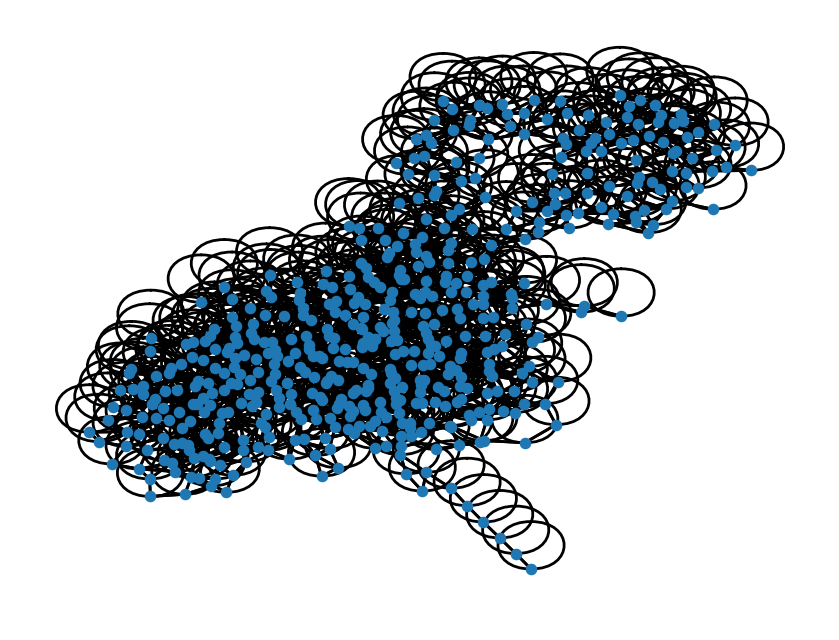

In [617]:
visualize_graph(pdb_graph)

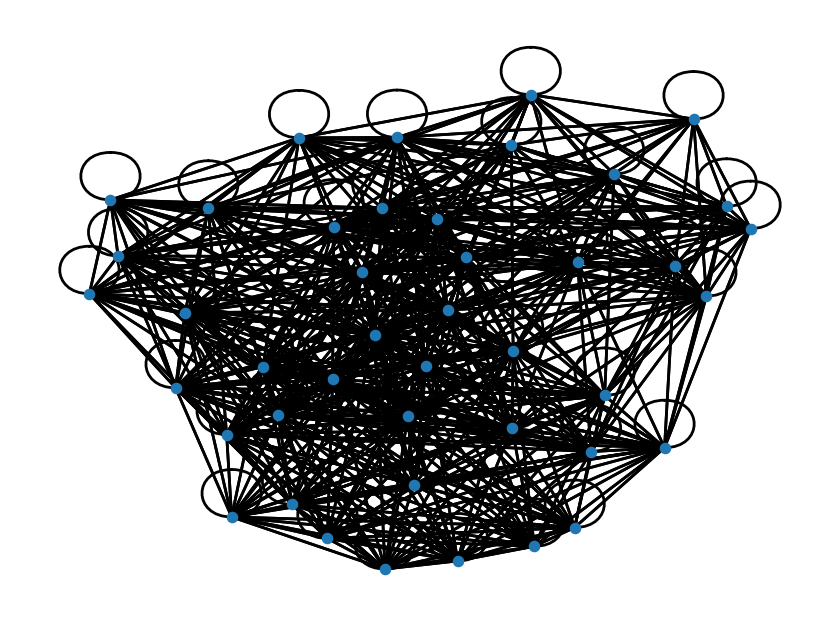

In [619]:
visualize_graph(mol2_graph)

In [549]:
dgl.save_graphs("dgl_graphs.bin", combined_graphs)
dgl.load_graphs("dgl_graphs.bin")

([Graph(num_nodes=281, num_edges=3801,
        ndata_schemes={}
        edata_schemes={}),
  Graph(num_nodes=285, num_edges=4061,
        ndata_schemes={}
        edata_schemes={}),
  Graph(num_nodes=158, num_edges=7442,
        ndata_schemes={}
        edata_schemes={}),
  Graph(num_nodes=292, num_edges=4572,
        ndata_schemes={}
        edata_schemes={}),
  Graph(num_nodes=294, num_edges=4596,
        ndata_schemes={}
        edata_schemes={}),
  Graph(num_nodes=280, num_edges=3778,
        ndata_schemes={}
        edata_schemes={}),
  Graph(num_nodes=286, num_edges=4098,
        ndata_schemes={}
        edata_schemes={}),
  Graph(num_nodes=286, num_edges=4176,
        ndata_schemes={}
        edata_schemes={}),
  Graph(num_nodes=288, num_edges=4296,
        ndata_schemes={}
        edata_schemes={}),
  Graph(num_nodes=280, num_edges=3930,
        ndata_schemes={}
        edata_schemes={}),
  Graph(num_nodes=290, num_edges=4530,
        ndata_schemes={}
        edata_schemes={}),

In [551]:
koff_data_cleaned['koff_main']

0      0.00653
1      0.23400
2      0.05000
3      0.93800
4      0.06050
        ...   
452    0.02500
453    0.06700
454    0.00012
455    0.00006
456    0.00100
Name: koff_main, Length: 457, dtype: float64

In [554]:
complex_names

0         1d4h_ligand_native_749
1         1d4i_ligand_native_771
2         1df8_ligand_native_359
3      1ebw_ligand_a015_762_dock
4      1ebw_ligand_a016_761_dock
                 ...            
452      6pgd_ligand_59_710_dock
453       6pgd_ligand_native_709
454       6rln_ligand_native_732
455       6slg_ligand_native_646
456       6un1_ligand_native_731
Name: ligand name, Length: 457, dtype: object